In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
import re
from scipy.spatial.distance import jaccard
from sklearn.cluster import SpectralClustering as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial import distance
from networkx.algorithms.community import k_clique_communities,girvan_newman
import itertools
import datetime

In [2]:
def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

def getThread(num,data):
    thread = data[data["ThreadID"]== threads[num]]
    members = thread["MemberID"].unique()
    thread = thread.reset_index(drop = True)
    
    for i in range(0,len(thread)):
        thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    
    #encode member names
    index = 0
    for i in range(0,len(members)):
        thread["MemberID"][thread["MemberID"] == members[i]] = index
        index += 1

    thread = thread.sort_values(by = ["P_Date",'MessageID'])
    
    return thread

### Load Data

In [3]:
data = pd.read_csv("../GawaherSentiment.csv")
threads = data["ThreadID"].unique()


### Thread over time

In [4]:
def makeGraph(thread):
    members = thread["MemberID"].unique()
    memberComments = []
    memberSentiments = []

    for i in members:
        memberComments.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(thread[thread["MemberID"] == i]["AllenNLP"].iloc[-1])

    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))

    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)

    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G, nodeDict, edgeDict, nx.information_centrality(G)

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.

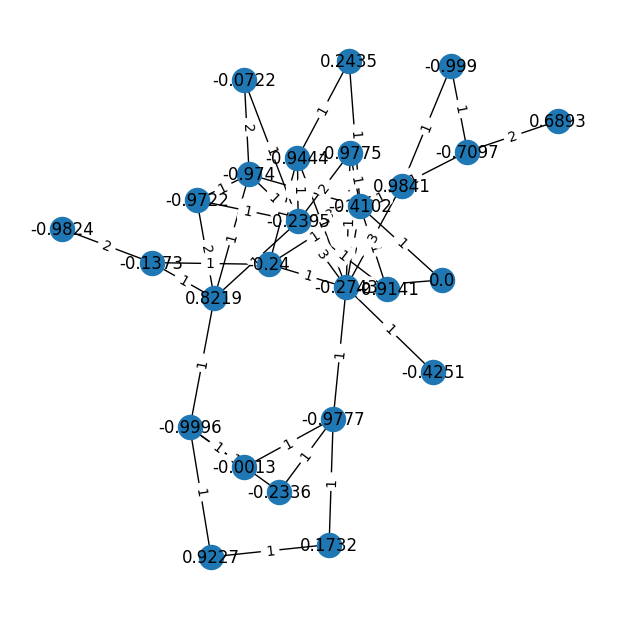

In [5]:
plt.figure(figsize = (6,6))
thread = getThread(0,data)
G, nodeDict, edgeDict, centrality = makeGraph(thread)

pos=nx.kamada_kawai_layout(G)
nx.draw(G, pos = pos, labels = nodeDict,  cmap='RdYlGn')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeDict);

### Feature Creation

In [68]:
deltaSentiments = []
connectionSentiments = []
connectionCentrality = []
meanSentiment = []
messageLength = []
edgeDegree = []
posterNumber = []

for i in range(0,len(threads)):
    thread = getThread(i,data)
    G, nodeDict, edgeDict, centrality = makeGraph(thread)
   
    for i in range(0,len(thread)-1):
        
        deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i+1]))
        #deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
            



C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [69]:
features = pd.DataFrame(np.array([posterNumber,connectionCentrality, messageLength,
                                  connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                       columns = ["posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])

In [70]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
features = features.sample(frac = 1)

### Model

In [77]:
import tensorflow as tf
from keras.layers import Dense,LSTM,Embedding, InputLayer, BatchNormalization
from keras.models import Sequential,Model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [71]:
xTrain = features[features.columns[:-1]].iloc[0:int(.8*len(features))]
yTrain = features[features.columns[-1]].iloc[0:int(.8*len(features))]
xTest = features[features.columns[:-1]].iloc[int(.8*len(features)):]
yTest = features[features.columns[-1]].iloc[int(.8*len(features)):]

"""
xScaler = StandardScaler().fit(xTrain)
yScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))

xTrain = xScaler.transform(xTrain)
yTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))

xTest = xScaler.transform(xTest)
yTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))


"""



'\nxScaler = StandardScaler().fit(xTrain)\nyScaler = StandardScaler().fit(yTrain.to_numpy().reshape(-1,1))\n\nxTrain = xScaler.transform(xTrain)\nyTrain = yScaler.transform(yTrain.to_numpy().reshape(-1,1))\n\nxTest = xScaler.transform(xTest)\nyTest = yScaler.transform(yTest.to_numpy().reshape(-1,1))\n\n'

In [72]:
xTrain = xTrain.to_numpy().reshape(-1,1,6)
xTest = xTest.to_numpy().reshape(-1,1,6)

In [78]:
batch = 32
epoch = 10
act = 'tanh'

model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(128, activation=act, return_sequences=True))
model.add(LSTM(128, activation=act, return_sequences=False))
model.add(Dense(10,activation=act))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse',metrics = ['mape'])
model.fit(xTrain, yTrain, batch_size= batch, epochs=epoch, verbose=1)



Epoch 1/10
3313/3313 [==============================] - 14s 3ms/step - loss: 0.0064 - mape: 316.9041
Epoch 2/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0058 - mape: 469.6129
Epoch 3/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0058 - mape: 357.2758
Epoch 4/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0056 - mape: 607.6567
Epoch 5/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0056 - mape: 523.3014
Epoch 6/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0056 - mape: 723.8492
Epoch 7/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0056 - mape: 665.4572
Epoch 8/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0057 - mape: 352.5480
Epoch 9/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0055 - mape: 418.8401
Epoch 10/10
3313/3313 [==============================] - 11s 3ms/step - loss: 0.0056 - mape

### Analysis

In [60]:
def featureExtract(i):
    deltaSentiments = []
    connectionSentiments = []
    connectionCentrality = []
    meanSentiment = []
    messageLength = []
    edgeDegree = []
    posterNumber = []

    thread = getThread(i,data)
    G, nodeDict, edgeDict, centrality = makeGraph(thread)
   
    for i in range(0,len(thread)-1):
        
        deltaSentiments.append(np.mean(thread["AllenNLP"].iloc[0:i+1]))
        #deltaSentiments.append(thread["AllenNLP"].iloc[i+1])
        connectionCentrality.append(centrality[thread["MemberID"].iloc[i]])
        meanSentiment.append(np.mean(thread["AllenNLP"].iloc[0:i]))
        messageLength.append(len(str(thread["Message"].iloc[i])))
        connectionSentiments.append(thread["AllenNLP"].iloc[i])
        edgeDegree.append(G.degree(thread["MemberID"].iloc[i]))
        posterNumber.append(thread["MemberID"].iloc[i])
        
    features = pd.DataFrame(np.array([posterNumber,connectionCentrality, messageLength,
                              connectionSentiments, edgeDegree,meanSentiment,deltaSentiments]).T,
                   columns = ["posterNumber","centrality","messageLength","sentiment","degree","meanSentiment","deltaSentiments"])

    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.dropna(inplace=True)


    return features

In [79]:
yPred = model.predict(xTest).reshape(-1,1)
#yPred = yScaler.inverse_transform(yPred)
#y = yScaler.inverse_transform(yTest)

829/829 [==============================] - 1s 1ms/step


In [80]:
r2_score(yTest,yPred)

0.9661880535615018

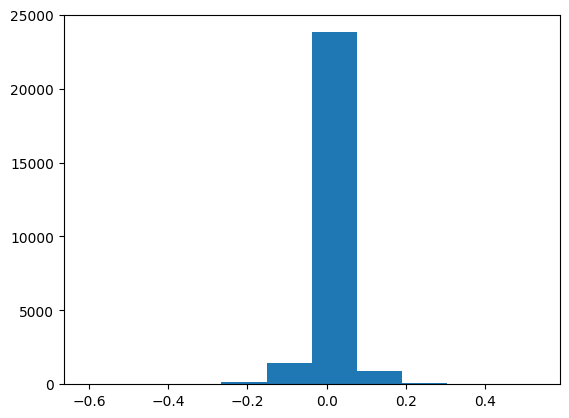

In [84]:
plt.hist(yTest.to_numpy().reshape(-1,1) - yPred);


In [85]:
test = featureExtract(0)

C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
C:\Users\Le\AppData\Local\Temp\ipykernel_13088\2970843534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = index


In [86]:
test

,posterNumber,centrality,messageLength,sentiment,degree,meanSentiment,deltaSentiments
1,0.0,0.031841,23908.0,0.142836,2.0,-0.183807,-0.020485
2,0.0,0.031841,3968.0,0.181680,2.0,-0.020485,0.046903
3,0.0,0.031841,3469.0,0.370321,2.0,0.046903,0.127758
4,0.0,0.031841,97.0,-0.005715,2.0,0.127758,0.101063
5,7.0,0.051035,380.0,0.198179,10.0,0.101063,0.117249
...,...,...,...,...,...,...,...
72,24.0,0.017535,66.0,0.689287,1.0,-0.292138,-0.278694
73,23.0,0.030275,272.0,-0.709671,3.0,-0.278694,-0.284518
74,25.0,0.028429,92.0,-0.998979,2.0,-0.284518,-0.294044
75,8.0,0.041583,62.0,0.984147,4.0,-0.294044,-0.277225


In [87]:
predTest = test[test.columns[:-1]]

In [93]:
preds = model.predict(predTest.to_numpy().reshape(-1,1,6))

3/3 [==============================] - 0s 2ms/step


In [96]:
preds.reshape(1,-1)

array([[-0.0145679 , -0.01570562,  0.05461895,  0.08079216,  0.07171139,
         0.04896218, -0.05861425, -0.06923388, -0.09304532, -0.13553762,
        -0.11592942, -0.19595516, -0.18514161, -0.17933823, -0.15765385,
        -0.13760448, -0.18287288, -0.13378659, -0.1801126 , -0.17574696,
        -0.1994025 , -0.18899702, -0.2055923 , -0.17676874, -0.18312488,
        -0.18566252, -0.18146685, -0.17524487, -0.17391998, -0.17952548,
        -0.20536406, -0.18986288, -0.20039658, -0.18634868, -0.19256504,
        -0.20869823, -0.20422982, -0.22522376, -0.21419677, -0.24128246,
        -0.225859  , -0.23499174, -0.25656116, -0.2576307 , -0.2518826 ,
        -0.2769872 , -0.28586003, -0.30598456, -0.28642794, -0.27653825,
        -0.27366954, -0.30278313, -0.28365096, -0.28496537, -0.3045981 ,
        -0.31541985, -0.27049184, -0.3049543 , -0.26036024, -0.28859326,
        -0.27170074, -0.26265705, -0.2682147 , -0.26152337, -0.28176606,
        -0.2758939 , -0.2911687 , -0.279822  , -0.2

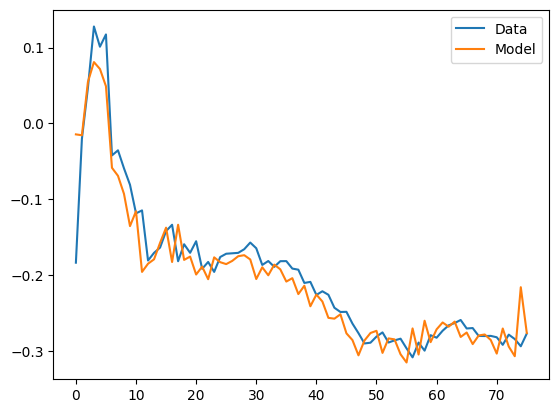

In [99]:
t = np.arange(0,len(test))
plt.plot(t,test["meanSentiment"], label = "Data")
plt.plot(t,preds.reshape(1,-1)[0], label = "Model")
plt.legend()